# CX Machine Translation services usage analysis

**Krishna Chaitanya Velaga, Data Scientist III, Wikimedia Foundation**

**Last Update: 25 October 2023**

[Ticket](https://phabricator.wikimedia.org/T338606) | [Codebase](https://github.com/wikimedia-research/machine-translation-service-analysis)

# Table of Contents

1. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Overall usage by machine translation service](#Overall-usage-by-machine-translation-service)
    * [YoY comparision](#YoY-comparision)
4. [Daily published translations](#Daily-published-translations)
5. [Usage by language pair](#Usage-by-language-pair) 
6. [Usage at each target language](#Usage-at-each-target-language)
7. [Percent machine translation content is modified](#Percent-machine-translation-content-is-modified)
8. [Percent of articles that are created with each MT service and deleted](#Percent-of-articles-that-are-created-with-each-MT-service-and-deleted)
    

# Purpose
Content translation supports multiple machine translation services.  When multiple options are available for a language, even if one is provided by default, users can use a different service. 
[See default configuration](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) and [languages supported](https://www.mediawiki.org/wiki/Help:Content_translation/Translating/Initial_machine_translation?useskin=vector-2022#Machine_translation_availability) files for details on all available language pairs and defaults. 

The purpose of the report is to understand the usage of MT services across various languages, and if needed inform changes to default service provided on certain language pairs. The previous iterations of the report have been run in May 2022 and later again in October 2022, to track changes due to [T309266](https://phabricator.wikimedia.org/T309266), [T307970](https://phabricator.wikimedia.org/T307970), and [T308248](https://phabricator.wikimedia.org/T308248). 

In this report, along with overall usage, we are specifically interested in the [MinT](https://www.mediawiki.org/wiki/MinT), which has exposed several translation models such as NLLB-200 and Opus to many languages.

# Methodology

For each machine translation service, we compared the following:
* Percent of translations published by each machine translation service:
    * Overall across all languages
    * Daily usage trends
    * Usage at each Language Pair (Source - Target)
    * Most frequently used service for each target Language
* Percent each machine translation service was modified by users
* Percent of articles created with each machine translation service that were deleted.

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table)

**All published translations from from August to September 2023 were considered for analysis.**

# Summary
**Overall usage**<br>
* Google Translate, which can be used to translate into all available languages except English, has been used for majority of the translations (81.35%) of the published translations across all language paris.
* MinT (Machine in Translation) which is a Wikimedia Foundation hosted open-source machine translation service, is now the second most used transaltion service accounting for 6.89% percent of all published translations. 
* No machine translation was used (scratch) for 6% of the published translations.

**YoY comparision**<br>*We compared the period of current analysis (August to September 2023) to the same period last year (August to September 2022) to observe changes in service usage.*
* The most significant change has been MinT now being the second most used translation service.
* Although Google is still the most used service, it's usage reduced by 5 percent points (86.44% to 81.35%).
* There has been slight increase (2 percent points; 3.95% to 6%) in percentage of translation that used no MT service (scratch).
* While Apertium's usage increased slightly, Yandex's usage decreased slightly.

**Languge pairs where an optional service was used more or close to the default**<br>*having at least five published translations*
* There are 24 language pairs where an optional service was used more or close to the default.
* In 50% of the cases, largely where Google was the default service, there are sustantial number of translations where no MT service was used (scratch).
* In 25% of the cases, Google was used more than the default service.
* Although, MinT is the default for en-zu, Google was used for 97% of the translations.
* For en-ku & en-st, MinT was used more than Google (the default service).

# imports anmd functions

In [69]:
import pandas as pd
import duckdb
import numpy as np
import warnings


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from IPython.display import display_html
from IPython.display import display, HTML

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import kaleido

In [112]:
init_notebook_mode(connected=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

bold = '\033[1m'
end = '\033[0m'
underline = '\033[4m'

iplot_width = 950

In [3]:
def pr_centered(content, bold=False):
    if bold:
        content = f"<b>{content}</b>"
    
    centered_html = f"<div style='text-align:center'>{content}</div>"
    
    display(HTML(centered_html))
    
def format_percent(column, df):
    return df[column].map('{:.2%}'.format)

def display_h(frames, space=100):
    html = ""
    
    for key in frames.keys():
        html_df =f'<div>{key} {frames[key]._repr_html_()}</div>'
        html += html_df
        
    html = f"""
    <div style="display:flex; justify-content: space-evenly;">
    {html}
    </div>"""
    
    display_html(html, raw=True)

In [7]:
conn = duckdb.connect('data_gathering/secrets/mt_data.db')

In [8]:
def query(query_string, df=False, conn=conn):
    if df==True:
        return conn.sql(query_string).df()
    else:
        return conn.sql(query_string).show()

In [6]:
conn.close()

# Overall-usage-across-all-languages

In [9]:
mt_compare_overall_2023 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-09-30'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [10]:
mt_compare_overall_2023_pr = mt_compare_overall_2023.copy()
mt_compare_overall_2023_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2023_pr)

In [11]:
pr_centered('Published translations by machine translations service across all language pairs', True)
pr_centered('August to September 2023')
display_h({
    '':mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,42896,81.35%
MinT,3634,6.89%
scratch,3164,6.00%
Apertium,1446,2.74%
Yandex,1076,2.04%
Elia,493,0.93%
LingoCloud,22,0.04%


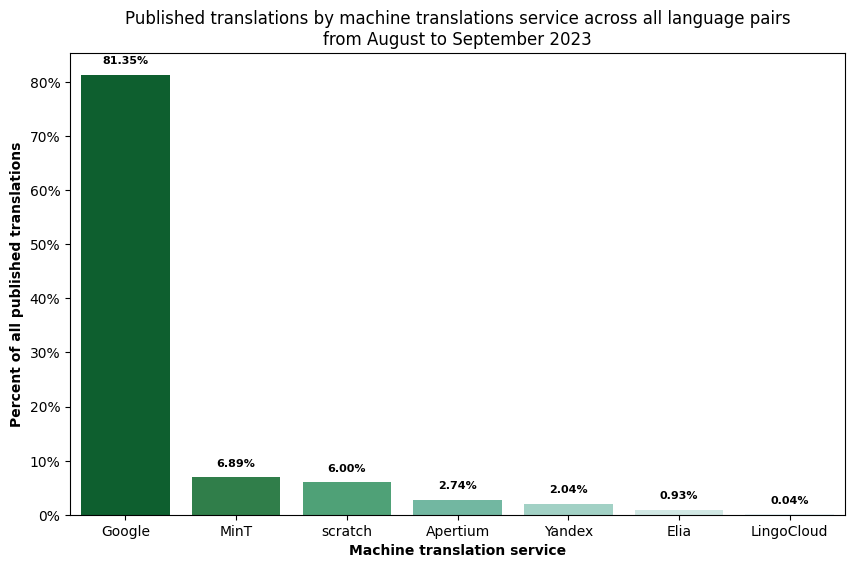

In [12]:
mt_compare_overall_2023['Percent of all published translations'] *= 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mt_compare_overall_2023, x='Machine translation service', y='Percent of all published translations', palette="BuGn_r")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

plt.title("Published translations by machine translations service across all language pairs\nfrom August to September 2023")
plt.xlabel("Machine translation service", fontweight='bold')
plt.ylabel("Percent of all published translations", fontweight='bold')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, fontweight='bold', color='black', 
                xytext=(0, 10), textcoords='offset points')

plt.show()

## Compare with 2022

In [13]:
mt_compare_overall_2022 = query("""
WITH
    base AS (
        SELECT 
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2022-08-01' AND
            translation_start_time <= '2022-09-30'
        GROUP BY
            mt_service
        ORDER BY
            n_translations DESC)


SELECT
    mt_service AS 'Machine translation service',
    n_translations AS 'Number of Translations',
    n_translations / SUM(n_translations) OVER () AS 'Percent of all published translations'
FROM
    base
""", True)

In [14]:
mt_compare_overall_2022_pr = mt_compare_overall_2022.copy()
mt_compare_overall_2022_pr['Percent of all published translations'] = format_percent('Percent of all published translations', mt_compare_overall_2022)

pr_centered('Published translations by machine translations service across all language pairs', True)
display_h({
    'August to September 2022': mt_compare_overall_2022_pr.set_index('Machine translation service'),
    'August to September 2023': mt_compare_overall_2023_pr.set_index('Machine translation service')
})

,Number of Translations,Percent of all published translations
Machine translation service,,
Google,48456,86.44%
scratch,2216,3.95%
Yandex,2156,3.85%
NLLB-200,1560,2.78%
Apertium,969,1.73%
Elia,625,1.11%
OpusMT,51,0.09%
LingoCloud,22,0.04%
MinT,4,0.01%


## Daily published translations
Translations published per day by each MT service were reviewed to identify any sudden increases or decreases in usage and to determine if those changes corresponded to deployments or setting changes that may have impacted MT availability.






In [15]:
mt_daily = query("""
WITH base AS (
    SELECT 
        mt_service,
        translation_start_time AS date,
        translation_id
    FROM 
        mt_logs
    WHERE
        translation_start_time >= '2022-08-01' AND
        translation_start_time <= '2023-09-30')

SELECT
    date,
    mt_service,
    COUNT(DISTINCT translation_id) AS n_translations
FROM
    base
GROUP BY
    date,
    mt_service
""", True)

In [16]:
warnings.filterwarnings('ignore')
mt_2023_daily = mt_daily.query("""'2023-04-01' <= date <= '2023-09-30'""")
mt_2023_daily.replace([np.inf, -np.inf], np.nan, inplace=True)
mt_2023_daily.dropna(subset=['date', 'n_translations'], inplace=True)

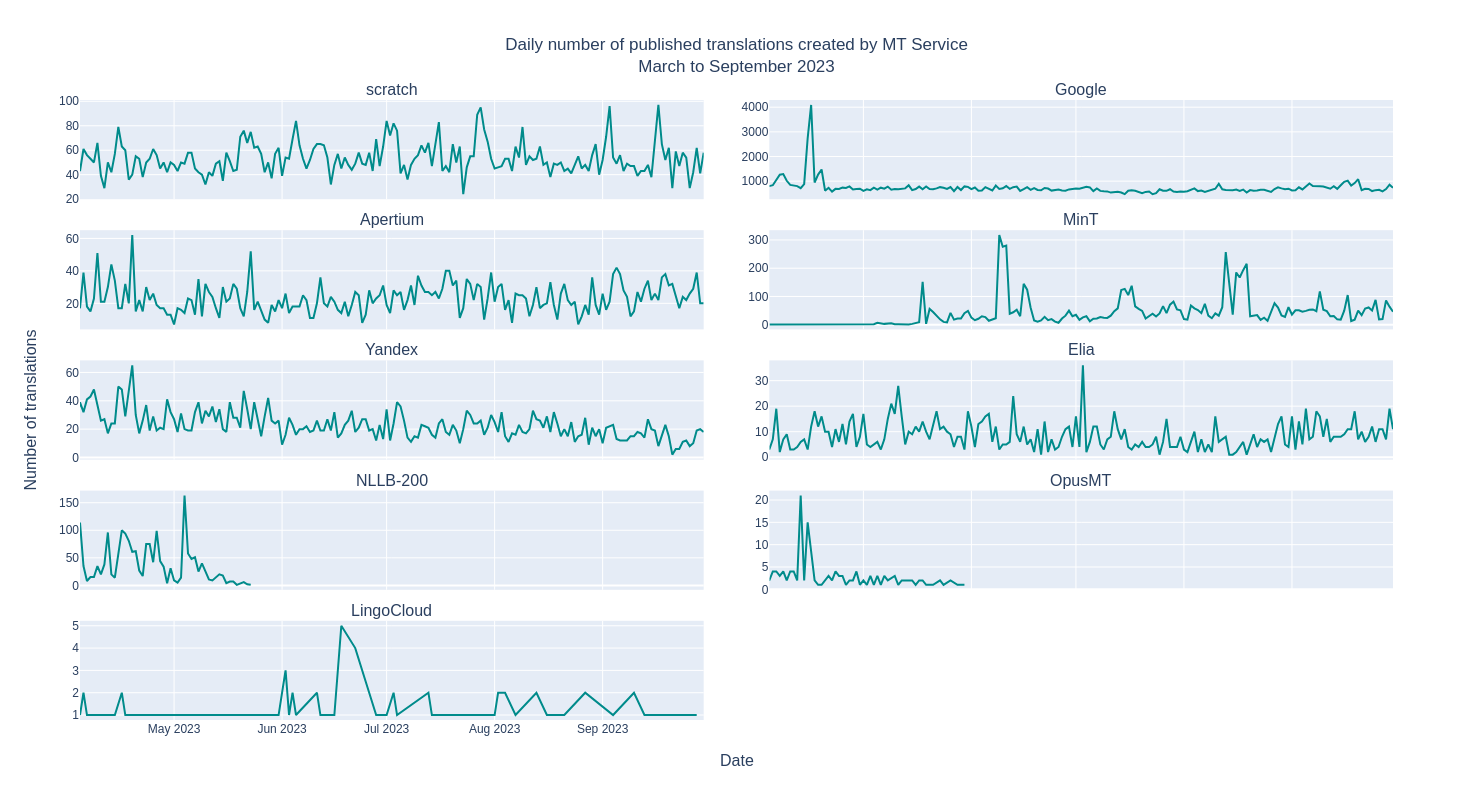

In [104]:
mt_services = mt_2023_daily.mt_service.unique()

fig = sp.make_subplots(rows=5, cols=2, 
                       shared_xaxes=True, 
                       subplot_titles=mt_services,
                       x_title='Date',
                       y_title='Number of translations',
                       vertical_spacing=0.05, 
                       horizontal_spacing=0.05)

for i, mt_service in enumerate(mt_services):
    row, col = divmod(i, 2)
    service_data = mt_2023_daily.query(f"mt_service == '{mt_service}'").sort_values('date')

    fig.add_trace(go.Scatter(x=service_data['date'], 
                             y=service_data['n_translations'], 
                             mode='lines',
                             name=mt_service,
                             showlegend=False, 
                             line=dict(color='DarkCyan')),
                  row=row+1, col=col+1)

fig.update_xaxes(range=[service_data['date'].min(), pd.to_datetime('2023-09-30')])
fig.update_layout(title_text="Daily number of published translations created by MT Service<br>March to September 2023",
                  title_x=0.5, height=800, width=iplot_width)

iplot(fig)

**Summary**
* With the deployment of MinT, around May/June 2023, NLLB-200's and OpusMT's direct usage ended as these are now integrated into MinT.
* As MinT deployments happened in stages, spikes can be seen at various instances when the MinT was enabled for new language pairs.
* The huge spike in Google's usage in April 2023, is specifically due to increased activity Uzbek Wikipedia, likely due to a translation campaign.
* Compared to 2022, the median number of daily translations from scratch, increased from 34 to 49.

In [18]:
def daily_avg(start_dt, end_dt, df=mt_daily):
    return (
        df    
        .query(f"""'{start_dt}' <= date <= '{end_dt}'""")
        .groupby('mt_service')
        .agg({'n_translations': 'median'})
        .astype(int)
        .sort_values('n_translations', ascending=False)
        .reset_index()
        .rename({
            'mt_service': 'Service', 
            'n_translations': '# Translations'
        }, axis=1)
    )

In [19]:
pr_centered('Number of Daily Translations (Median)', True)
display_h({
    'August to September 2022': daily_avg('2022-08-01', '2022-09-30'),
    'April to May 2023': daily_avg('2023-04-01', '2023-05-31'),
    'August to September 2023': daily_avg('2023-08-01', '2023-09-30')
})

,Service,# Translations
0,Google,760
1,scratch,34
2,Yandex,29
3,Apertium,14
4,NLLB-200,12
5,Elia,8
6,LingoCloud,1
7,MinT,1
8,OpusMT,1
,Service,# Translations


## Usage by language pair
The number and percentage of publications by each machine translation service at each language pair (i.e., source language and target language) were reviewed. Due to the large combination of language pairs, the data was saved to a [Google Spreadsheet](to be linked) to easily filter and identify the percentage of publications by language pair for each machine translation service.

In [20]:
mt_by_langpair = query("""
WITH
    base AS (
        SELECT
            source_language,
            target_language,
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM 
            mt_logs
        WHERE
            translation_start_time >= '2023-08-01' AND
            translation_start_time <= '2023-09-30'
        GROUP BY
            source_language,
            target_language,
            mt_service
        ORDER BY
            source_language,
            target_language,
            n_translations)

SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY source_language, target_language) AS pct_translations
FROM
    base
""", True)

In [21]:
mt_by_langpair.to_csv('data_gathering/secrets/mt_usage_langpair.tsv', sep='\t', index=False)

## Languge pairs where an optional service was used more or close to the default

In [22]:
mt_defaults = query("""
WITH
    base AS (
    SELECT
        *,
        source_language||'-'||target_language AS pair
    FROM
        mt_by_langpair mt
    )
    
SELECT 
    b.* EXCLUDE(mt_service),
    b.mt_service AS service_used,
    dfs.service AS default_service
FROM 
    base b
    JOIN mt_defaults dfs
    ON b.pair = dfs.language_pair
WHERE
    service_type = 'default_mt'
""", True)

In [23]:
mt_optional_services_used_more = mt_defaults[
    (mt_defaults['service_used'] != mt_defaults['default_service']) & 
    (mt_defaults['pct_translations'] > 0.25) &
    (mt_defaults['n_translations'] > 5)
]

mt_optional_services_used_more_pr = mt_optional_services_used_more.copy()
mt_optional_services_used_more_pr = (
    mt_optional_services_used_more_pr
    .rename(columns={
        'source_language': 'Source',
        'target_language': 'Target',
        'n_translations': '# Translations',
        'pct_translations': '% of Translations',
        'service_used': 'MT service used',
        'default_service': 'Default service'
    })
    .set_index(['Default service', 'Source']))

mt_optional_services_used_more_pr.sort_values(['Default service', '% of Translations'], ascending=False, inplace=True)
mt_optional_services_used_more_pr['% of Translations'] = format_percent('% of Translations', mt_optional_services_used_more_pr)

In [24]:
pr_centered('Languge pairs where an optional service was used more or close to the default', True)
pr_centered('(having at least five published translations)')
display_h({
    '': mt_optional_services_used_more_pr
})

Target 
 # Translations 
 % of Translations 
 pair 
 MT service used 
 
 
 Default service 
 Source 
 
 
 
 
 
 
 
 
 
 MinT 
 en 
 zu 
 34 
 97.14% 
 en-zu 
 Google 
 
 
 Google 
 en 
 ja 
 46 
 100.00% 
 en-ja 
 scratch 
 
 
 tr 
 en 
 7 
 100.00% 
 tr-en 
 scratch 
 
 
 en 
 de 
 11 
 100.00% 
 en-de 
 scratch 
 
 
 ar 
 en 
 20 
 90.91% 
 ar-en 
 scratch 
 
 
 de 
 lb 
 29 
 90.62% 
 de-lb 
 Yandex 
 
 
 uk 
 be 
 43 
 81.13% 
 uk-be 
 Yandex 
 
 
 fa 
 en 
 33 
 80.49% 
 fa-en 
 scratch 
 
 
 he 
 en 
 11 
 78.57% 
 he-en 
 scratch 
 
 
 be 
 uk 
 7 
 77.78% 
 be-uk 
 Yandex 
 
 
 en 
 ku 
 9 
 75.00% 
 en-ku 
 MinT 
 
 
 fr 
 en 
 11 
 68.75% 
 fr-en 
 scratch 
 
 
 he 
 yi 
 9 
 60.00% 
 he-yi 
 Yandex 
 
 
 en 
 st 
 8 
 57.14% 
 en-st 
 MinT 
 
 
 en 
 id 
 262 
 42.88% 
 en-id 
 scratch 
 
 
 en 
 fa 
 503 
 32.04% 
 en-fa 
 scratch 
 
 
 it 
 fr 
 12 
 31.58% 
 it-fr 
 scratch 
 
 
 ar 
 om 
 9 
 29.03% 
 ar-om 
 scratch 
 
 
 Elia 
 en 
 eu 
 40 
 38.46% 
 en-eu 
 Google 
 
 
 es 
 eu 
 195 
 36.72% 
 es-eu 
 Google 
 
 
 Apertium 
 es 
 en 
 11 
 64.71% 
 es-en 
 scratch 
 
 
 en 
 gl 
 67 
 50.00% 
 en-gl 
 Google 
 
 
 nl 
 af 
 8 
 50.00% 
 nl-af 
 Google 
 
 
 es 
 ca 
 128 
 35.16% 
 es-ca 
 Google

## Usage at each target language
Next, a closer look was taken at each machine translation service, identifying its usage at all target languages where available and determining the languages each service is helping to support the most. 

In [25]:
def chart_order_services(services, selected_service):
    services.remove(selected_service) 
    services.sort()
    services.insert(0, selected_service)
    return services

In [75]:
def chart_usage(service, min_translations=10, min_percent=0.1, chart_height=750, chart_width=1400, xlabel_offset=0.025, return_fig=False):
    service_usage_by_target = query(f"""
        WITH
            languages AS (
                SELECT 
                    DISTINCT target_language
                FROM 
                    mt_logs
                WHERE
                    translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-09-30' 
                    AND mt_service = '{service}'),

            base AS (
                SELECT
                    *
                FROM
                    mt_logs
                WHERE
                    target_language IN (SELECT target_language FROM languages)
                    AND translation_start_time >= '2023-08-01' 
                    AND translation_start_time <= '2023-09-30' ),

            agg AS (
                SELECT
                    target_language,
                    mt_service,
                    COUNT(DISTINCT translation_id) AS n_translations
                FROM
                    base
                GROUP BY
                    target_language,
                    mt_service
                ORDER BY
                    target_language,
                    n_translations DESC)
                    
        SELECT
            *,
            n_translations / SUM(n_translations) OVER (PARTITION BY target_language) AS pct_translations
        FROM
            agg
        """, True)
    
    top_langs = (
        service_usage_by_target
        .query(f"""(mt_service == @service) & (n_translations >= {min_translations}) & (pct_translations > {min_percent})""")
        .sort_values(['pct_translations'], ascending=False)
        .target_language
        .values
        .tolist()
    )
    
    top_langs_usage = (
        service_usage_by_target
        .query("""target_language == @top_langs""")
        .assign(
            target_language=lambda df: pd.Categorical(
                df['target_language'], 
                categories=top_langs, 
                ordered=True),
            mt_service=lambda df: pd.Categorical(
                df['mt_service'], 
                categories=chart_order_services(df.mt_service.unique().tolist(), service), 
                ordered=True)
        )
        .sort_values(['target_language', 'mt_service'])
    )
    
    if service == 'scratch':
        chart_title = f'Languages most where no MT service was used (scratch)'
    else:
        chart_title = f'Languages most supported by {service} (by percentage of published translations)'
    
    fig = px.bar(top_langs_usage, 
                 y='target_language', 
                 x='pct_translations', 
                 color='mt_service', 
                 orientation='h', 
                 height=chart_height, 
                 width=chart_width,
                 color_discrete_sequence=px.colors.qualitative.T10,
                 labels={
                     'target_language': 'Target language', 
                     'pct_translations': 'Percent of all published translations', 
                     'mt_service': 'MT service'
                 },
                 title=chart_title,
                 category_orders={'target_language': top_langs})
    
    fig.update_xaxes(tickformat=".0%")
    annotations = []
    
    for _, row in top_langs_usage.iterrows():
        if row['mt_service'] == service:
            annotations.append(
                dict(
                    x=row['pct_translations'] - xlabel_offset,
                    y=row['target_language'],
                    text=f"{row['pct_translations']:.0%}",
                    showarrow=False,
                    font=dict(color="white")
                )
            )
            
    fig.update_layout(annotations=annotations)
    
    if return_fig:
        return fig
    else:
        fig.show()

In [27]:
print(f'Available services: {mt_by_langpair.mt_service.unique().tolist()}')

Available services: ['MinT', 'Google', 'Yandex', 'scratch', 'Apertium', 'Elia', 'LingoCloud']


### MinT
[MinT (Machine in Translation)](https://www.mediawiki.org/wiki/MinT) is a machine translation service based on open-source neural machine translation models. The service is hosted in the Wikimedia Foundation infrastructure, and it runs translation models that have been released by other organizations with an open-source license. MinT is designed to provide translations from multiple machine translation models. Initially, it uses the following models: NLLLB-200, OpusMT, IndicTrans2 and Softcatalà. From August to September 2023, MinT account for 6.89% of all published translations, ranking second by usage.

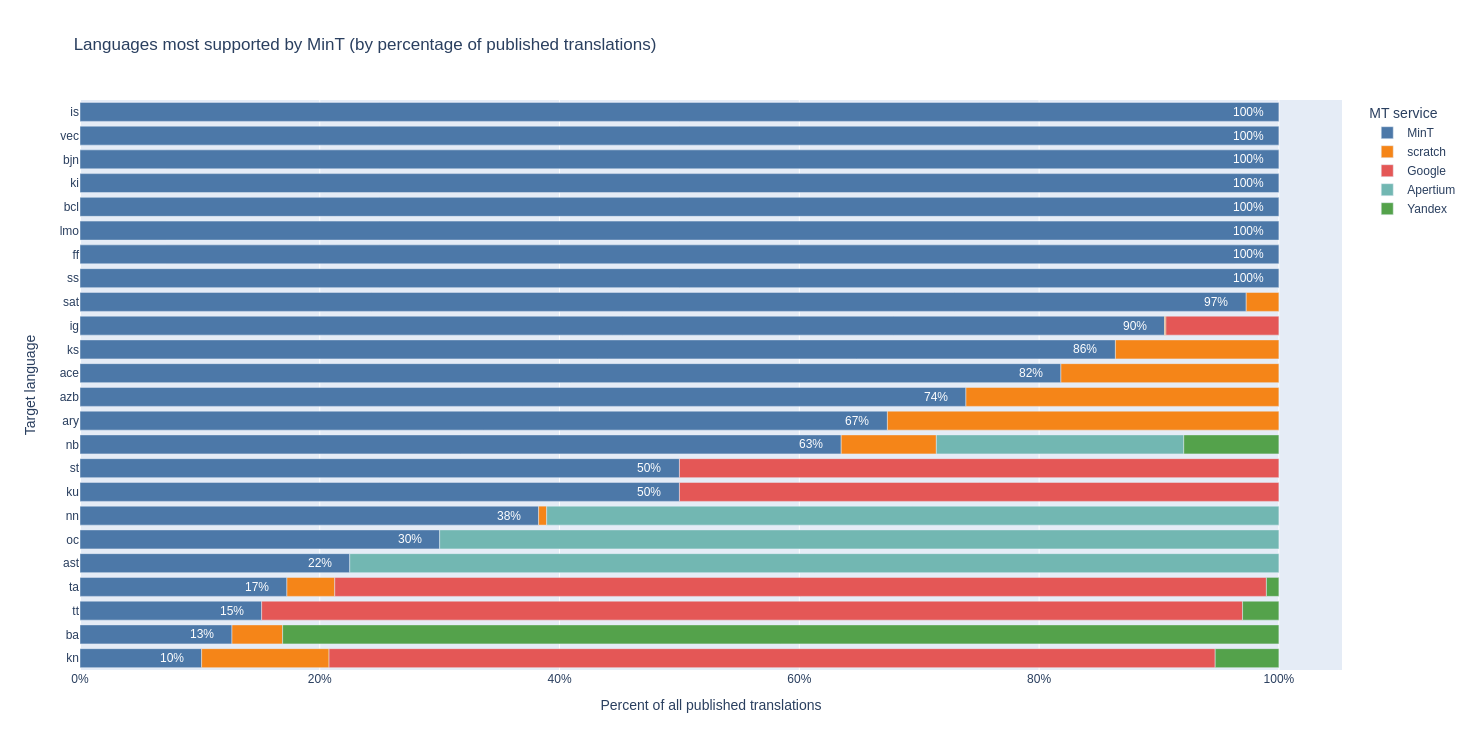

In [374]:
iplot(chart_usage('MinT', chart_height=750, chart_width=iplot_width, return_fig=True, min_translations=5))

**Summary**<br>*among languages where there have been at least 5 published translations, and MinT accounted for at least 10% of the translations*
- MinT is currently used to support 100% of published translations at Venetian (Vec), Bikol Central (bcl), Fulah (ff), and Swati (ss). 
- On Santali (sat), Igbo (ig), Kashmiri (ks), South Azerbaijani (azb), Moroccan Arabic (ary), and Norwegian (nb), MinT accounts for majority of the translations.

### Google
[Google Translate](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Google_Translate&useskin=vector-2022) is the most frequently used machine translation service (used for 81.35% of all published translations) and supports about 100 languages.

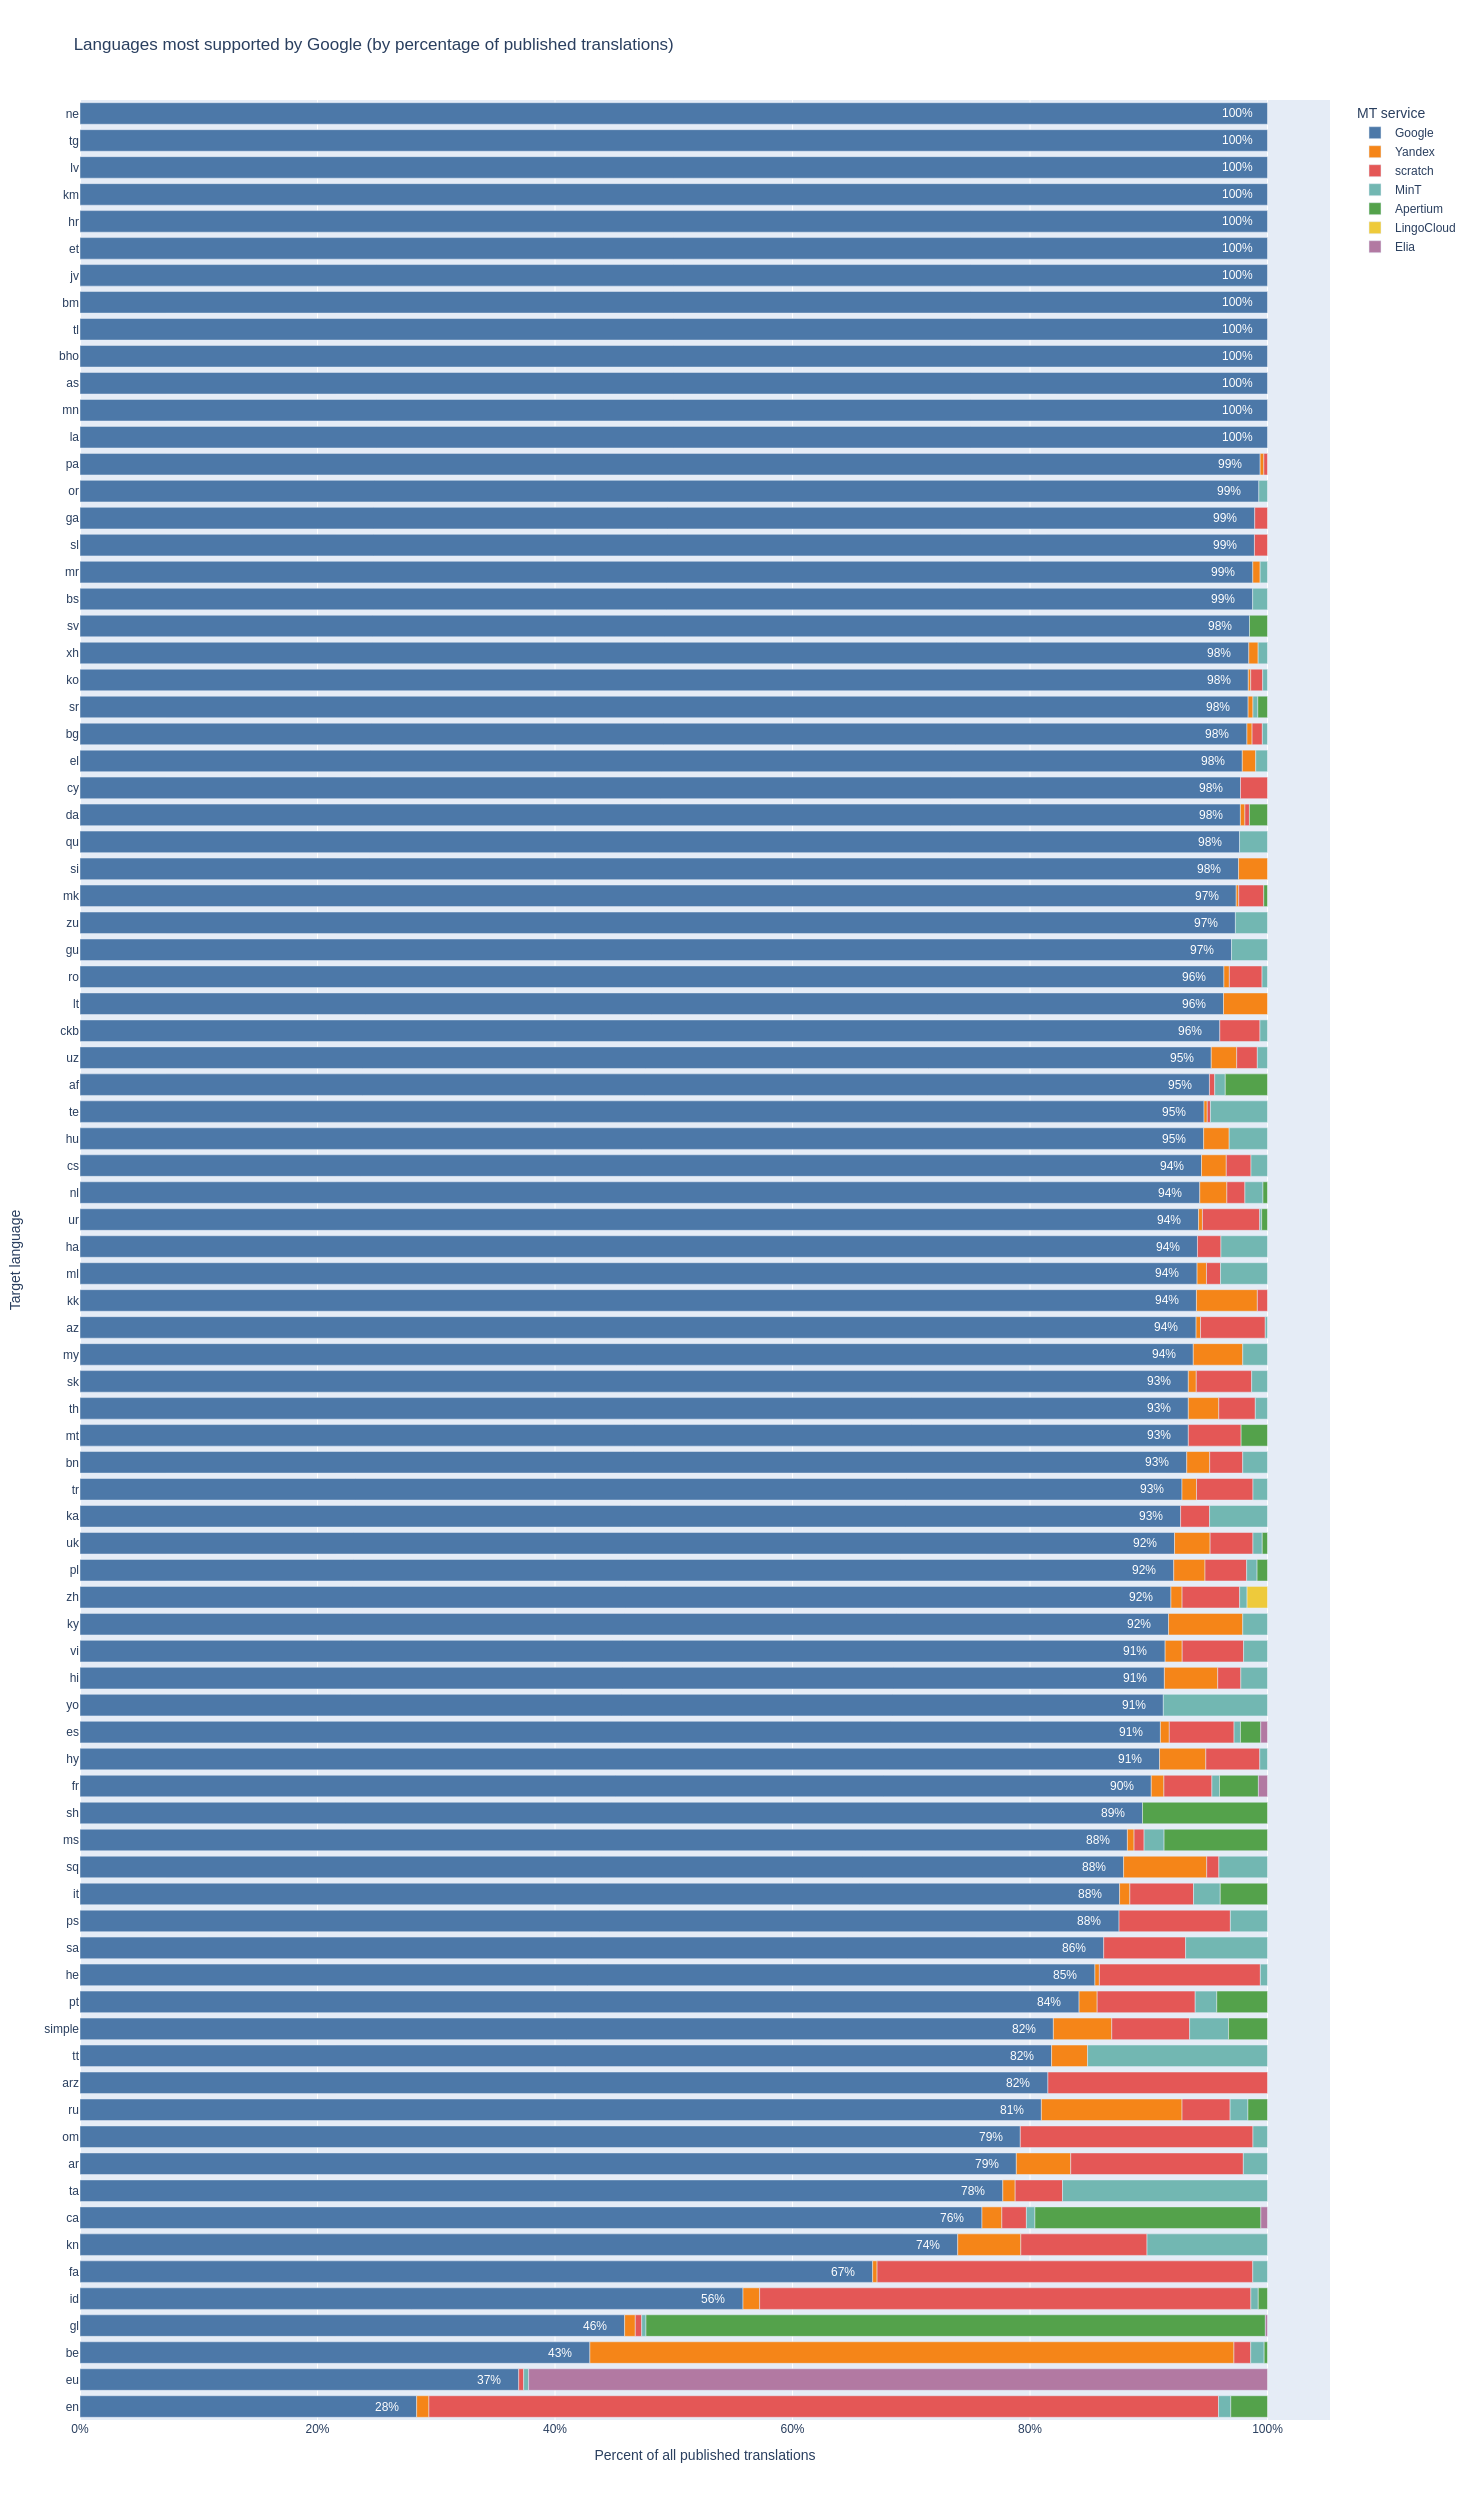

In [382]:
iplot(chart_usage('Google', chart_height=2500, chart_width=iplot_width, return_fig=True))

**Summary**<br>*among languages where there have been at least 10 published translations, and MinT accounted for at least 10% of the translations*
- Google Translate was used to translate 100% of translations at many target languages including languages where it is the default or only available service. 
- In 83 languages, where Google is used for majority of the published translations.

### Yandex
[Yandex](https://www.mediawiki.org/w/index.php?title=Content_translation/Machine_Translation/Yandex&useskin=vector-2022) has been available for Content Translation tool users since 4 November 2015. During August and September 2023, it accounted for 2% of all published translations.

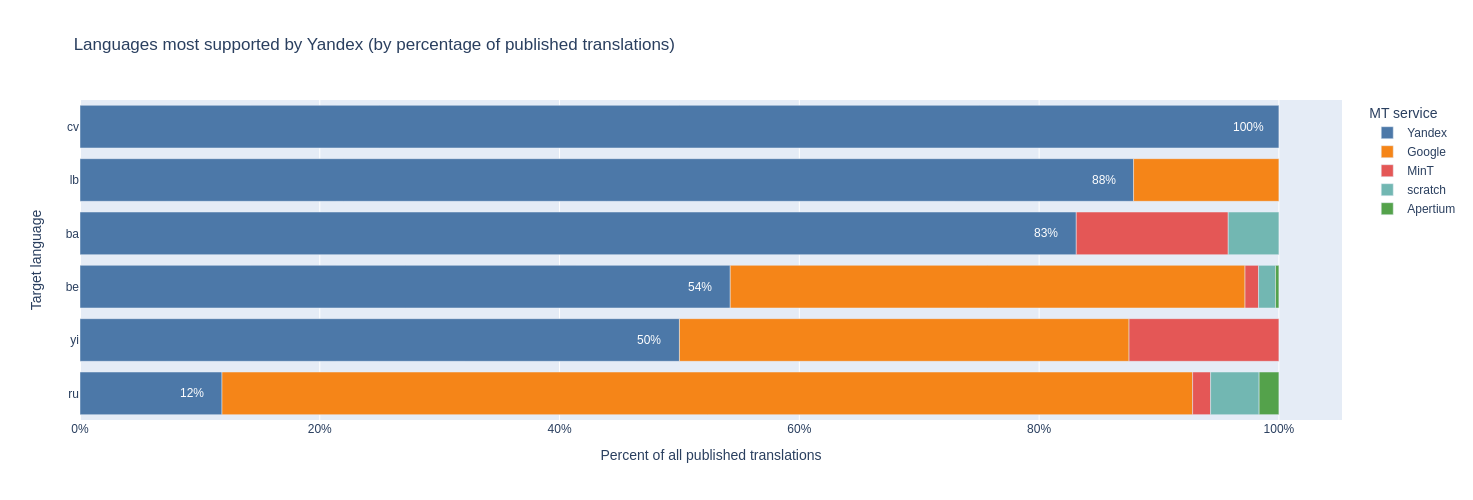

In [375]:
iplot(chart_usage('Yandex', chart_height=500, chart_width=iplot_width, return_fig=True, min_translations=5))

**Summary**<br>*among languages where there have been at least 5 published translations, and MinT accounted for at least 10% of the translations*
* Yandex is used for majority of the translations on Chuvash (cv), Luxembourgish (lb), Bashkir (ba), Belarusian (be), and Yiddish (yi).

### Apertium

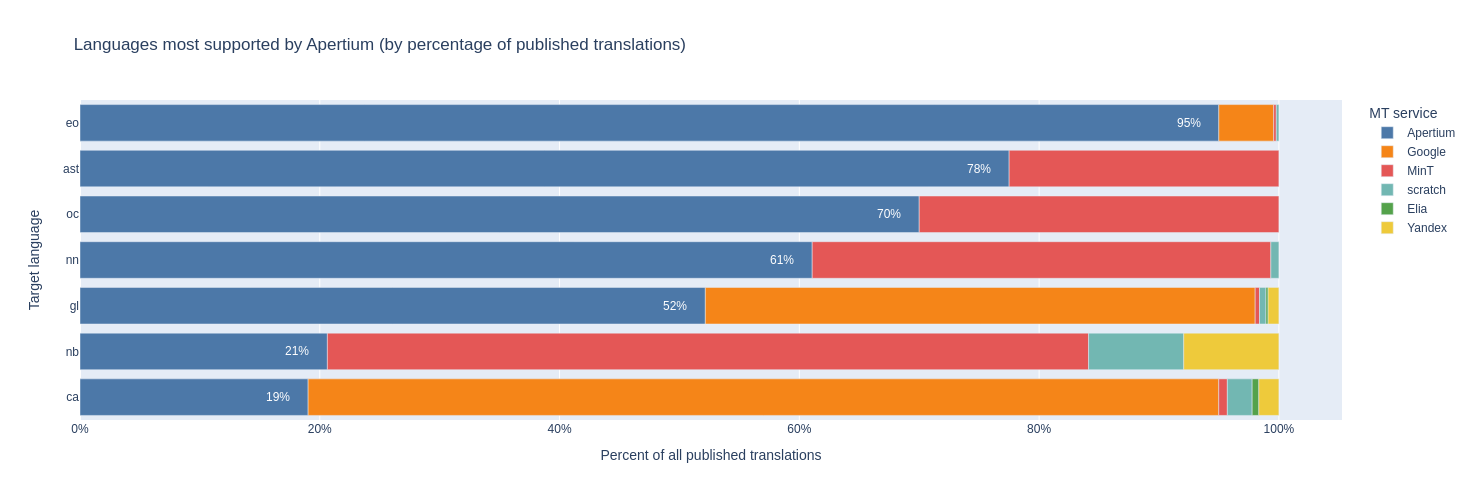

In [380]:
iplot(chart_usage('Apertium', chart_height=500, chart_width=iplot_width, return_fig=True, min_translations=5))

### Elia

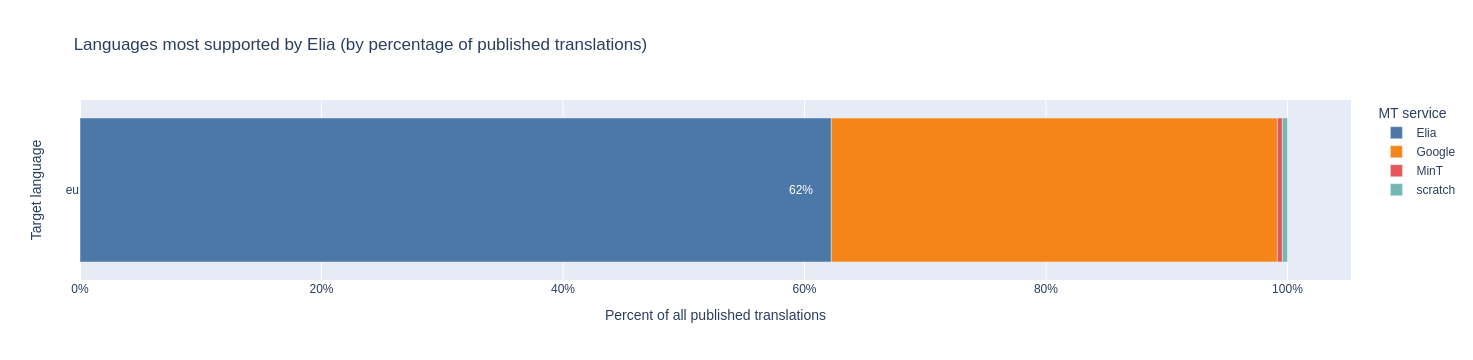

In [109]:
iplot(chart_usage('Elia', min_translations=5, min_percent=0.05, chart_height=300, chart_width=iplot_width, return_fig=True))

### LingoCloud

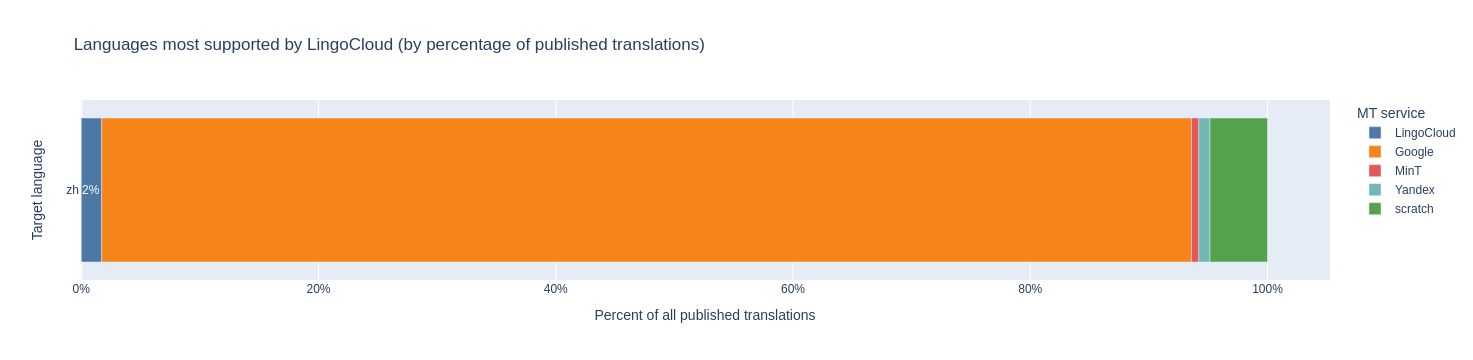

In [110]:
iplot(chart_usage('LingoCloud', min_translations=1, min_percent=0, chart_height=300, xlabel_offset=0.009, chart_width=iplot_width, return_fig=True))

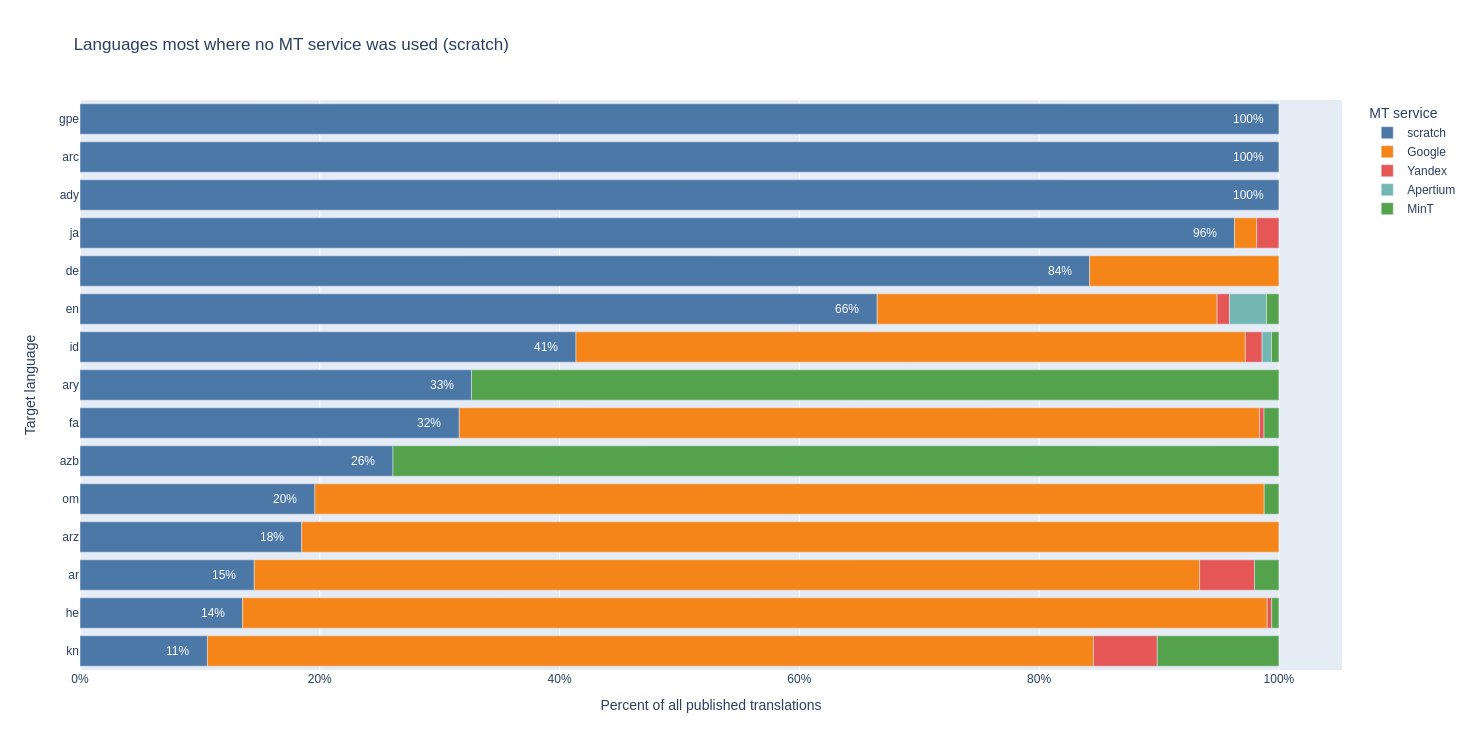

In [111]:
iplot(chart_usage('scratch', chart_height=750, chart_width=iplot_width, return_fig=True))

## Percent machine translation content is modified

The content provided by each machine translation service can be modified by the user before publishing. We track the percent each translation is modified by the user. Per the MT abuse calculation documentation, a warning or error is shown to user depending on how much unmodified content is present. This encourages the user to edit it further. In some cases users are still able to publish, but the resulting page may get added to a tracking category of potentially unreviewed translations for the community to review. In other cases, users may not be allowed to publish.

For the purpose of this analysis, we limited the analysis to only published translations and reviewed the percent the machine translation content was modified by users into three categories: less than 10%, between 10 and 50%, and over 50%. These categories can be adjusted as needed.

**Method:** Data on percent each translation is modified comes from the translations_progress field [^Note] in the cx_translation table (as indicated by the human percentage stat).

[^Note]: The translations_progress data shows the percentage of translation completion. human indicates manual translation percentage. mt indicates machine translation percentage. Any edits to machine translation output are considered as manual edits. The percentages are calculated at section level. any indicates the total translation (any=human+mt). Content Translation does not demand full translation of the source article.

In [139]:
conn.sql("""
CREATE OR REPLACE VIEW hpct_modified AS
SELECT
    *,
    CASE 
        WHEN human_translated_percent < 0.1 THEN 'less than 10%'
        WHEN human_translated_percent >= 0.1 AND human_translated_percent <= 0.5 THEN 'between 10% and 50%'
        WHEN human_translated_percent >0.5 THEN 'over 50%'
    END AS 'pct_modified'
FROM
    mt_logs
WHERE
    translation_start_time >= '2023-08-01' 
    AND translation_start_time <= '2023-09-30'
    AND mt_service != 'scratch'
""")

In [200]:
pct_modified_overall = query("""
WITH 
    base AS (
        SELECT
            mt_service,
            pct_modified,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        GROUP BY
            mt_service,
            pct_modified
        )
        
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY mt_service) AS pct_translations
FROM
    base
""", True)

In [445]:
pct_order = ['less than 10%', 'between 10% and 50%', 'over 50%']
def chart_pct_modified(df, title, pct_order=pct_order, iplot_width=800):
    mt_service_order = (
        df
        .query("""pct_modified == 'less than 10%'""")
        .sort_values('pct_translations', ascending=False)
        .mt_service
        .unique()
        .tolist()
    )

    df['mt_service'] = pd.Categorical(df['mt_service'], categories=mt_service_order, ordered=True)
    df['pct_modified'] = pd.Categorical(df['pct_modified'], categories=pct_order, ordered=True)
    df = df.sort_values(['mt_service', 'pct_modified'], ascending=[True, True])

    fig = px.bar(df, 
                 y='mt_service', 
                 x='pct_translations', 
                 color='pct_modified', 
                 orientation='h', 
                 height=600, 
                 width=iplot_width,
                 color_discrete_sequence=px.colors.qualitative.T10,
                 labels={
                     'mt_service': 'MT service', 
                     'pct_translations': 'Percent of all published translations', 
                     'pct_modified': 'Percent modified by user'
                 },
                 title=title
                )

    fig.update_xaxes(tickformat=".0%")

    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    return fig

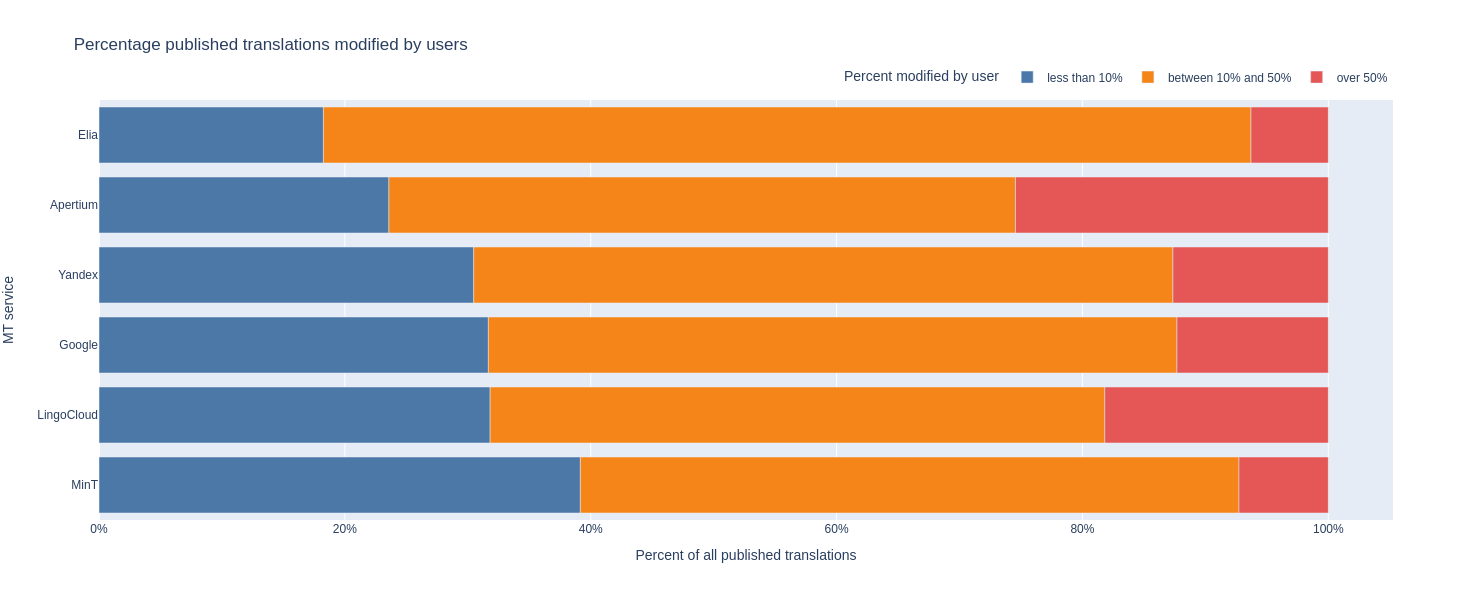

In [446]:
iplot(chart_pct_modified(pct_modified_overall, 'Percentage published translations modified by users'))

### MinT supported languages

In [185]:
pct_modified_mint_langs = query("""
WITH
    mint_langs AS (
        SELECT
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            mt_service = 'MinT'
        GROUP BY
            target_language
    ),
    
    base AS (
        SELECT
            mt_service,
            pct_modified,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            target_language IN (SELECT DISTINCT target_language FROM mint_langs WHERE n_translations >= 10)
        GROUP BY
            mt_service,
            pct_modified
        )
    
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY mt_service) AS pct_translations
FROM
    base
""", True)

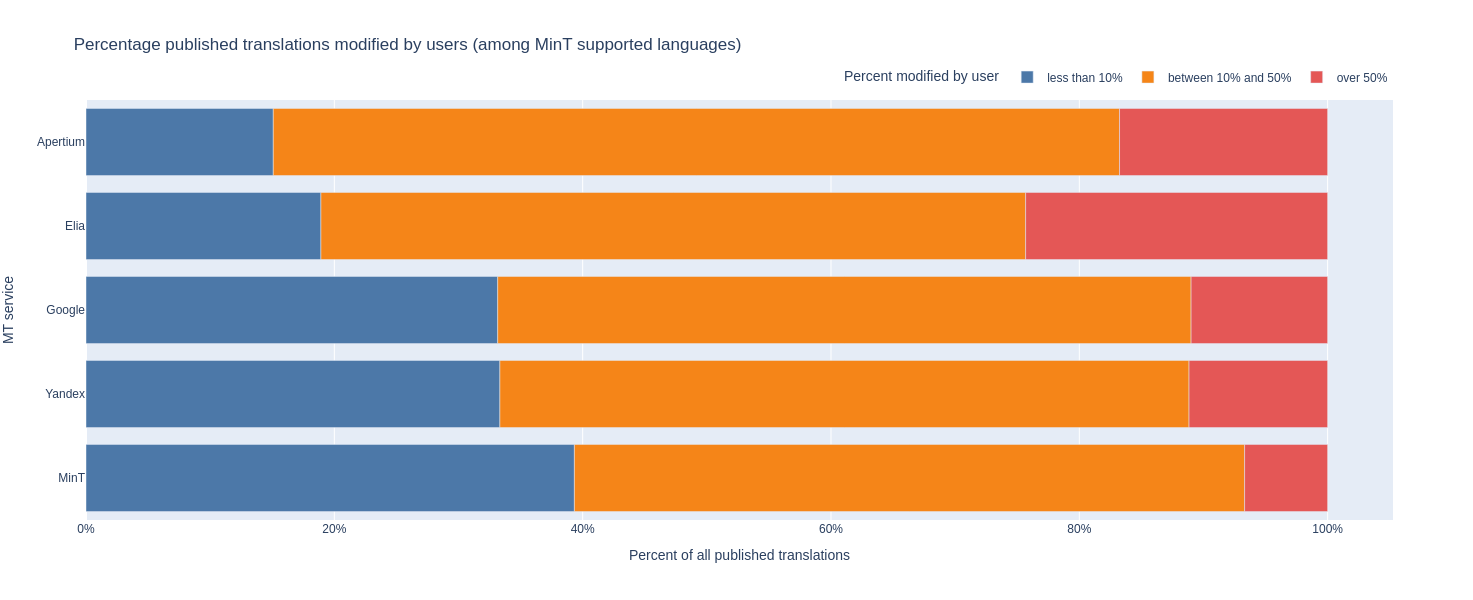

In [447]:
iplot(chart_pct_modified(pct_modified_mint_langs, 'Percentage published translations modified by users (among MinT supported languages)'))

In [390]:
pct_modified_mint_by_lang = query("""
WITH
    mint_langs AS (
        SELECT
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            mt_service = 'MinT'
        GROUP BY
            target_language
    ),
    
    base AS (
        SELECT
            mt_service,
            pct_modified,
            target_language,
            COUNT(DISTINCT translation_id) AS n_translations
        FROM
            hpct_modified
        WHERE
            target_language IN (SELECT DISTINCT target_language FROM mint_langs WHERE n_translations >= 10)
        GROUP BY
            mt_service,
            pct_modified,
            target_language
        )
    
SELECT
    *,
    n_translations / SUM(n_translations) OVER (PARTITION BY target_language, mt_service) AS pct_translations
FROM
    base
""", True)

In [391]:
pct_modified_mint_by_lang['pct_modified'] = pd.Categorical(pct_modified_mint_by_lang['pct_modified'], categories=pct_order, ordered=True)
pct_modified_mint_by_lang = pct_modified_mint_by_lang.sort_values(['pct_modified'], ascending=[True])

In [442]:
color_mapping = {
    'less than 10%': px.colors.qualitative.T10[0],
    'between 10% and 50%': px.colors.qualitative.T10[1],
    'over 50%': px.colors.qualitative.T10[2]
}

fig = sp.make_subplots(rows=num_rows, cols=3, subplot_titles=unique_target_languages, horizontal_spacing=0.1, vertical_spacing=0.025, shared_xaxes=True, specs=[[{}, {}, {}]]*num_rows)

all_traces = []

for i, target_language in enumerate(unique_target_languages):
    row_num = i // 3 + 1
    col_num = i % 3 + 1
    
    filtered_data = pct_modified_mint_by_lang.query(f"target_language == '{target_language}'")
    
    traces = []
    categories = filtered_data['pct_modified'].unique()

    # Create a trace for each category and append it to the traces list
    for category in categories:
        category_data = filtered_data[filtered_data['pct_modified'] == category]
        
        trace = go.Bar(
            x=category_data['pct_translations'],
            y=category_data['mt_service'],
            orientation='h',
            name=category,
            marker=dict(color=color_mapping[category]),
            text=[f"{val:.0%}" if val > 0.2 else '' for val in category_data['pct_translations']],  # Format text labels as percentages,
            textposition='auto',
            textfont=dict(size=10)
        )
        
        traces.append(trace)
        
        
    for trace in traces:
        fig.add_trace(trace, row=row_num, col=col_num)

    
fig.update_layout(
    title="Percentage published translations modified by users at MinT supported languages",
    height=200 * num_rows,
    width=950,
    barmode='stack',
    showlegend=False
)

for row_num in range(1, num_rows + 1):
    for col_num in range(1, 4):  # Assuming 3 columns
        fig.update_xaxes(tickformat=".0%", row=row_num, col=col_num)

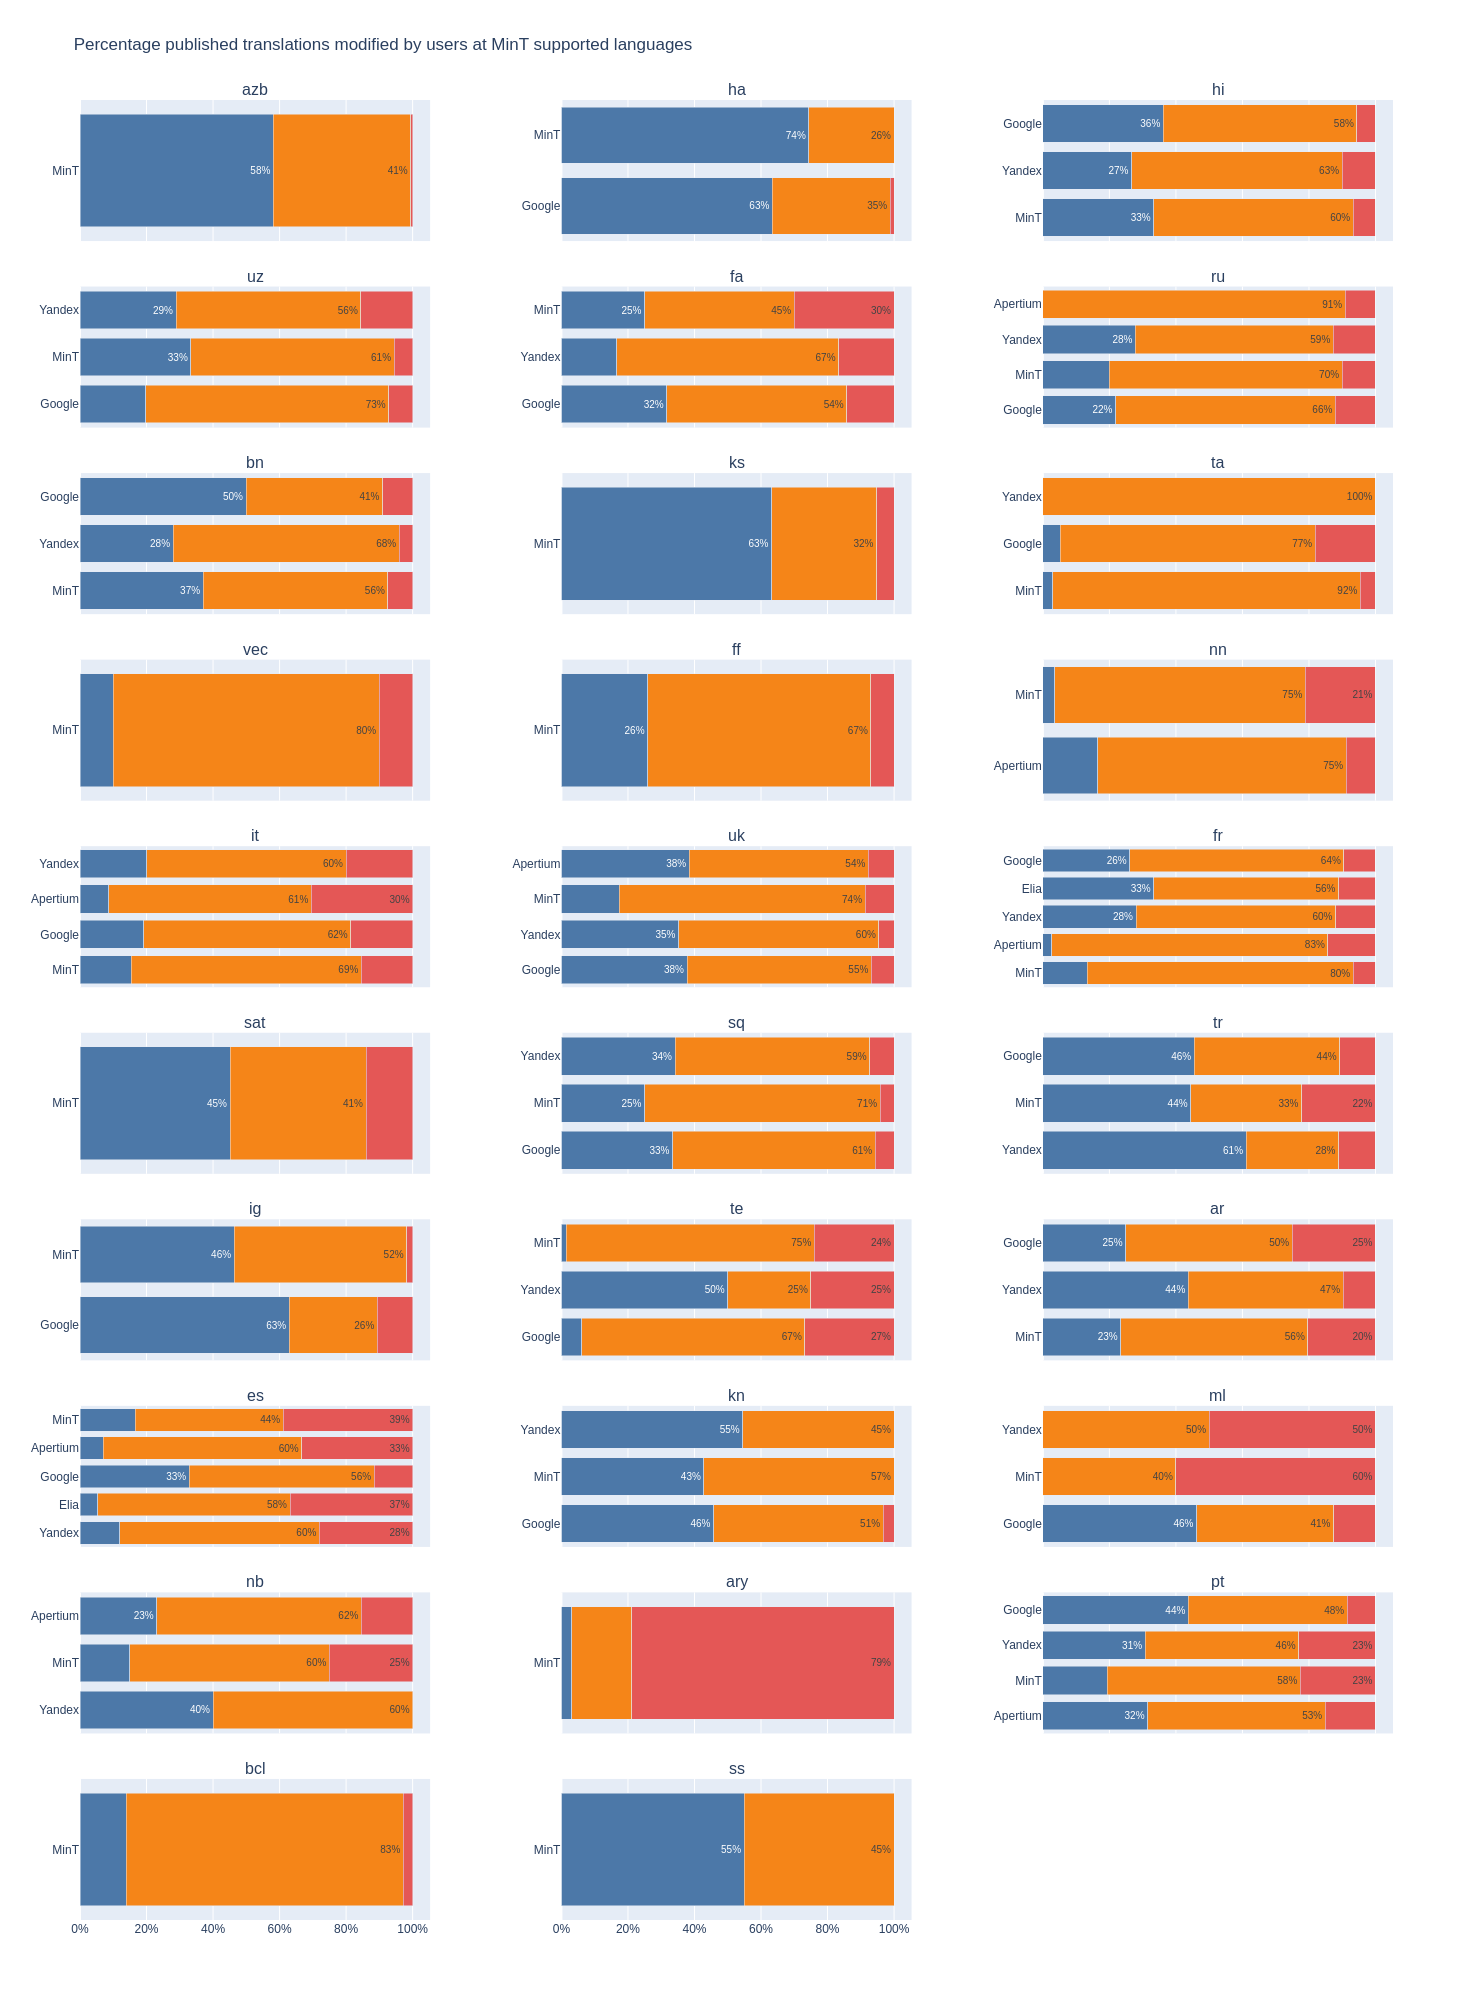

In [443]:
iplot(fig)

## YoY comparision

In [413]:
yoy_comparision_service_comparision = query(f"""
WITH
    base AS (
        SELECT
            source_language,
            target_language,
            mt_service,
            COUNT(DISTINCT translation_id) AS n_translations,
            EXTRACT(YEAR FROM translation_start_time) AS translation_year
        FROM 
            mt_logs
        WHERE
            (translation_start_time >= '2023-08-01' AND translation_start_time <= '2023-09-30')
            OR
            (translation_start_time >= '2022-08-01' AND translation_start_time <= '2022-09-30')
        GROUP BY
            source_language,
            target_language,
            mt_service,
            translation_year
    )
SELECT
    source_language,
    target_language,
    mt_service,
    SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) AS n_translations_2022,
    SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) AS n_translations_2023,
    CASE 
        WHEN SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) > 0
        THEN SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END) / 
             SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END +
                 CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END)
        ELSE NULL
    END AS pct_translations_2022,
    CASE 
        WHEN SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) > 0
        THEN SUM(CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END) / 
             SUM(CASE WHEN translation_year = 2022 THEN n_translations ELSE 0 END +
                 CASE WHEN translation_year = 2023 THEN n_translations ELSE 0 END)
        ELSE NULL
    END AS pct_translations_2023
FROM
    base
GROUP BY
    source_language,
    target_language,
    mt_service
ORDER BY
    source_language,
    target_language,
    mt_service
    """, True)

In [440]:
def calculate_yoy_differences(service, df=yoy_comparision_service_comparision, min_diff=0.40, min_translations=25):
    filtered_df = df[(df['mt_service'] == service) & (df['n_translations_2022'] > min_translations)]
    
    filtered_df['pct_diff'] = filtered_df['pct_translations_2023'] - filtered_df['pct_translations_2022']
    
    filtered_df = filtered_df[abs(filtered_df['pct_diff']) >= min_diff]
    
    formatted_df = filtered_df.copy()
    percentage_columns = ['pct_translations_2022', 'pct_translations_2023', 'pct_diff']
    for col in percentage_columns:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
    
    filtered_df = filtered_df.astype({'n_translations_2022': int, 'n_translations_2023': int})
    
    column_mapping = {
        'source_language': 'Source',
        'target_language': 'Target',
        'n_translations_2022': '# Translations 2022',
        'n_translations_2023': '# Translations 2023',
        'pct_translations_2022': '% of Translations 2022',
        'pct_translations_2023': '% of Translations 2023',
        'pct_diff': '% Difference of all Translations',
    }
    formatted_df.rename(columns=column_mapping, inplace=True)
    
    formatted_df.set_index(['Source', 'Target'], inplace=True)
    
    return formatted_df

In [441]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Google', True)
pr_centered('with minimum 25 published translations and the difference is more than 40%')
display_h({
    '': calculate_yoy_differences('Google')
})


mt_service 
 # Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 
 ar 
 ckb 
 Google 
 28.0 
 146.0 
 16.09% 
 83.91% 
 67.82% 
 
 
 az 
 ka 
 Google 
 33.0 
 3.0 
 91.67% 
 8.33% 
 -83.33% 
 
 
 bs 
 sr 
 Google 
 83.0 
 2.0 
 97.65% 
 2.35% 
 -95.29% 
 
 
 ceb 
 es 
 Google 
 71.0 
 13.0 
 84.52% 
 15.48% 
 -69.05% 
 
 
 de 
 hr 
 Google 
 30.0 
 2.0 
 93.75% 
 6.25% 
 -87.50% 
 
 
 ru 
 Google 
 32.0 
 8.0 
 80.00% 
 20.00% 
 -60.00% 
 
 
 tr 
 Google 
 34.0 
 14.0 
 70.83% 
 29.17% 
 -41.67% 
 
 
 en 
 af 
 Google 
 62.0 
 205.0 
 23.22% 
 76.78% 
 53.56% 
 
 
 da 
 Google 
 63.0 
 245.0 
 20.45% 
 79.55% 
 59.09% 
 
 
 fi 
 Google 
 41.0 
 7.0 
 85.42% 
 14.58% 
 -70.83% 
 
 
 ga 
 Google 
 205.0 
 79.0 
 72.18% 
 27.82% 
 -44.37% 
 
 
 ha 
 Google 
 1116.0 
 2979.0 
 27.25% 
 72.75% 
 45.49% 
 
 
 id 
 Google 
 101.0 
 342.0 
 22.80% 
 77.20% 
 54.40% 
 
 
 kn 
 Google 
 425.0 
 153.0 
 73.53% 
 26.47% 
 -47.06% 
 
 
 ko 
 Google 
 187.0 
 464.0 
 28.73% 
 71.27% 
 42.55% 
 
 
 ku 
 Google 
 63.0 
 3.0 
 95.45% 
 4.55% 
 -90.91% 
 
 
 sq 
 Google 
 108.0 
 360.0 
 23.08% 
 76.92% 
 53.85% 
 
 
 sw 
 Google 
 26.0 
 1.0 
 96.30% 
 3.70% 
 -92.59% 
 
 
 te 
 Google 
 119.0 
 1383.0 
 7.92% 
 92.08% 
 84.15% 
 
 
 ur 
 Google 
 2950.0 
 1142.0 
 72.09% 
 27.91% 
 -44.18% 
 
 
 uz 
 Google 
 10464.0 
 2912.0 
 78.23% 
 21.77% 
 -56.46% 
 
 
 vi 
 Google 
 121.0 
 303.0 
 28.54% 
 71.46% 
 42.92% 
 
 
 yo 
 Google 
 192.0 
 49.0 
 79.67% 
 20.33% 
 -59.34% 
 
 
 es 
 ar 
 Google 
 34.0 
 14.0 
 70.83% 
 29.17% 
 -41.67% 
 
 
 bn 
 Google 
 46.0 
 2.0 
 95.83% 
 4.17% 
 -91.67% 
 
 
 eu 
 Google 
 67.0 
 195.0 
 25.57% 
 74.43% 
 48.85% 
 
 
 fa 
 Google 
 36.0 
 1.0 
 97.30% 
 2.70% 
 -94.59% 
 
 
 fr 
 ar 
 Google 
 32.0 
 220.0 
 12.70% 
 87.30% 
 74.60% 
 
 
 cs 
 Google 
 34.0 
 6.0 
 85.00% 
 15.00% 
 -70.00% 
 
 
 es 
 Google 
 361.0 
 140.0 
 72.06% 
 27.94% 
 -44.11% 
 
 
 nl 
 Google 
 38.0 
 15.0 
 71.70% 
 28.30% 
 -43.40% 
 
 
 gl 
 es 
 Google 
 95.0 
 18.0 
 84.07% 
 15.93% 
 -68.14% 
 
 
 he 
 eo 
 Google 
 60.0 
 2.0 
 96.77% 
 3.23% 
 -93.55% 
 
 
 hu 
 he 
 Google 
 46.0 
 152.0 
 23.23% 
 76.77% 
 53.54% 
 
 
 it 
 fr 
 Google 
 163.0 
 26.0 
 86.24% 
 13.76% 
 -72.49% 
 
 
 ja 
 zh 
 Google 
 55.0 
 160.0 
 25.58% 
 74.42% 
 48.84% 
 
 
 kk 
 uz 
 Google 
 215.0 
 2.0 
 99.08% 
 0.92% 
 -98.16% 
 
 
 pl 
 uk 
 Google 
 38.0 
 132.0 
 22.35% 
 77.65% 
 55.29% 
 
 
 ru 
 sr 
 Google 
 28.0 
 2.0 
 93.33% 
 6.67% 
 -86.67% 
 
 
 tg 
 Google 
 44.0 
 11.0 
 80.00% 
 20.00% 
 -60.00% 
 
 
 uz 
 Google 
 2883.0 
 959.0 
 75.04% 
 24.96% 
 -50.08% 
 
 
 simple 
 uz 
 Google 
 33.0 
 4.0 
 89.19% 
 10.81% 
 -78.38% 
 
 
 sr 
 mk 
 Google 
 54.0 
 153.0 
 26.09% 
 73.91% 
 47.83% 
 
 
 tr 
 az 
 Google 
 33.0 
 79.0 
 29.46% 
 70.54% 
 41.07% 
 
 
 uz 
 Google 
 203.0 
 68.0 
 74.91% 
 25.09% 
 -49.82% 
 
 
 uk 
 ru 
 Google 
 111.0 
 30.0 
 78.72% 
 21.28% 
 -57.45% 
 
 
 ur 
 ps 
 Google 
 246.0 
 28.0 
 89.78% 
 10.22% 
 -79.56%

In [422]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Yandex', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Yandex', min_diff=0.25).drop('mt_service', axis=1)
})


# Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 en 
 ar 
 26.0 
 137.0 
 15.95% 
 84.05% 
 68.10% 
 
 
 bn 
 58.0 
 25.0 
 69.88% 
 30.12% 
 -39.76% 
 
 
 fa 
 32.0 
 6.0 
 84.21% 
 15.79% 
 -68.42% 
 
 
 he 
 44.0 
 4.0 
 91.67% 
 8.33% 
 -83.33% 
 
 
 nb 
 103.0 
 2.0 
 98.10% 
 1.90% 
 -96.19% 
 
 
 pa 
 28.0 
 1.0 
 96.55% 
 3.45% 
 -93.10% 
 
 
 tr 
 27.0 
 16.0 
 62.79% 
 37.21% 
 -25.58% 
 
 
 uz 
 548.0 
 70.0 
 88.67% 
 11.33% 
 -77.35% 
 
 
 ru 
 ba 
 116.0 
 58.0 
 66.67% 
 33.33% 
 -33.33% 
 
 
 uz 
 115.0 
 19.0 
 85.82% 
 14.18% 
 -71.64% 
 
 
 uk 
 be 
 516.0 
 43.0 
 92.31% 
 7.69% 
 -84.62%

In [430]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Elia', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Elia', min_diff=0.25).drop('mt_service', axis=1)
})


,,# Translations 2022,# Translations 2023,% of Translations 2022,% of Translations 2023,% Difference of all Translations
Source,Target,,,,,
en,eu,118.0,62.0,65.56%,34.44%,-31.11%


In [432]:
pr_centered('Languages pairs where has been a major change in percentage of translations made using Apertium', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '': calculate_yoy_differences('Apertium', min_diff=0.25).drop('mt_service', axis=1)
})


# Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 en 
 eo 
 100.0 
 386.0 
 20.58% 
 79.42% 
 58.85% 
 
 
 gl 
 120.0 
 66.0 
 64.52% 
 35.48% 
 -29.03% 
 
 
 es 
 gl 
 65.0 
 222.0 
 22.65% 
 77.35% 
 54.70%

In [437]:
pr_centered('Languages pairs where has been a major change in percentage of translations made without use of any machine translation', True)
pr_centered('with minimum 25 published translations and the difference is more than 25%')
display_h({
    '':  calculate_yoy_differences('scratch', min_diff=0.25, min_translations=10).drop('mt_service', axis=1)
})

# Translations 2022 
 # Translations 2023 
 % of Translations 2022 
 % of Translations 2023 
 % Difference of all Translations 
 
 
 Source 
 Target 
 
 
 
 
 
 
 
 
 
 en 
 ar 
 135.0 
 388.0 
 25.81% 
 74.19% 
 48.37% 
 
 
 bn 
 15.0 
 35.0 
 30.00% 
 70.00% 
 40.00% 
 
 
 es 
 69.0 
 151.0 
 31.36% 
 68.64% 
 37.27% 
 
 
 fa 
 286.0 
 503.0 
 36.25% 
 63.75% 
 27.50% 
 
 
 id 
 136.0 
 262.0 
 34.17% 
 65.83% 
 31.66% 
 
 
 pt 
 39.0 
 120.0 
 24.53% 
 75.47% 
 50.94% 
 
 
 ru 
 18.0 
 10.0 
 64.29% 
 35.71% 
 -28.57% 
 
 
 uz 
 233.0 
 27.0 
 89.62% 
 10.38% 
 -79.23% 
 
 
 zh 
 82.0 
 46.0 
 64.06% 
 35.94% 
 -28.12% 
 
 
 es 
 fr 
 23.0 
 12.0 
 65.71% 
 34.29% 
 -31.43% 
 
 
 he 
 en 
 19.0 
 11.0 
 63.33% 
 36.67% 
 -26.67% 
 
 
 ru 
 az 
 13.0 
 7.0 
 65.00% 
 35.00% 
 -30.00% 
 
 
 be 
 31.0 
 3.0 
 91.18% 
 8.82% 
 -82.35%